<a href="https://colab.research.google.com/github/DingLi23/s2search/blob/pipelining/pipelining/ale-exp1/ale-exp1_cslg_2w_ale_plotting.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Experiment Description

1-way ALE.

> This notebook is for experiment \<ale-exp1\> and data sample \<cslg\>.

### Initialization

In [12]:
%load_ext autoreload
%autoreload 2
import numpy as np, sys, os
in_colab = 'google.colab' in sys.modules
# fetching code and data(if you are using colab
if in_colab:
    !rm -rf s2search
    !git clone --branch pipelining https://github.com/youyinnn/s2search.git
    sys.path.insert(1, './s2search')
    %cd s2search/pipelining/ale-exp1/

pic_dir = os.path.join('.', 'plot')
if not os.path.exists(pic_dir):
    os.mkdir(pic_dir)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading data

In [13]:
sys.path.insert(1, '../../')
import numpy as np, sys, os, pandas as pd
from getting_data import read_conf
from s2search_score_pdp import pdp_based_importance

sample_name = 'cslg'

f_list = [
    'title', 
    'abstract', 
    'venue', 
    'authors', 
    'year', 
    'n_citations'
    ]
ale_rs = []
ale_metric = pd.DataFrame(columns=['f1_name', 'f2_name', 'mean', 'var', 'std', 'ale_based_feature_interaction'])

def replace_quantile(feature_name, quantile):
    if feature_name == 'year' or feature_name == 'n_citations':
        return quantile
    else:
        return list(range(len(quantile)))
    
def norm(arr):
  if np.mean(arr) != 0:
    norm = np.linalg.norm(arr)
    arr = arr / norm
    
  return arr

mean_arr = []
var_arr = []
std_arr = []
fi_arr = []

for i in range(len(f_list)):
    f1_name = f_list[i]
    for j in range(i + 1, len(f_list)):
        f2_name = f_list[j]
        file = os.path.join('.', 'scores', f'{sample_name}_2w_ale_{f1_name}_{f2_name}.npz')
        if os.path.exists(file):
            nparr = np.load(file)
            quantile_1 = nparr['quantile_1']
            quantile_2 = nparr['quantile_2']
            ale_result = nparr['ale_result']
            
            mean_arr.append(np.mean(ale_result))
            var_arr.append(np.var(ale_result, ddof=1))
            std_arr.append(np.std(ale_result, ddof=1))
            std_f1_imp_on_f2 = np.std([pdp_based_importance(row, f1_name) for row in ale_result], ddof=1)
            std_f2_imp_on_f1 = np.std([pdp_based_importance(row, f2_name) for row in np.flipud(np.rot90(ale_result))], ddof=1)
            fi_arr.append(round(np.mean([std_f1_imp_on_f2, std_f2_imp_on_f1]), 10))
            
            t = f'The mean of the 2-way ale - ({f1_name} * {f2_name})'
            
            ale = {
                'ale': norm(ale_result),
                'f1_quantile': replace_quantile(f1_name, quantile_1),
                'f2_quantile': replace_quantile(f2_name, quantile_2),
                'f1_name': f1_name,
                'f2_name': f2_name,
                'title': t
            }
            
            
            ale_rs.append(ale)
            
# mean_arr = norm(mean_arr) 
# var_arr = norm(var_arr) 
# std_arr = norm(std_arr)
# fi_arr = norm(fi_arr)

# pd.options.display.float_format = '{:,.46f}'.format
pd.set_option('display.expand_frame_repr', False)

idx = 0
for i in range(len(f_list)):
    f1_name = f_list[i]
    for j in range(i + 1, len(f_list)):
        f2_name = f_list[j]
        ale_metric.loc[len(ale_metric.index)] = [f1_name, f2_name, mean_arr[idx], var_arr[idx], std_arr[idx], fi_arr[idx]]
        idx += 1

print(ale_metric.sort_values(by=['std'], ascending=False))


     f1_name      f2_name          mean           var           std  ale_based_feature_interaction
14      year  n_citations  5.717526e+40  3.137230e+84  1.771223e+42                   1.732994e+42
7   abstract         year -6.614032e+34  3.981798e+72  1.995444e+36                   1.946886e+36
8   abstract  n_citations  2.865290e+29  7.849639e+61  8.859819e+30                   8.666115e+30
3      title         year  2.533976e+23  4.736921e+49  6.882529e+24                   6.629051e+24
0      title     abstract -1.496379e+19  2.033382e+41  4.509304e+20                   4.397813e+20
4      title  n_citations -2.997010e+17  7.874178e+37  8.873656e+18                   8.637828e+18
5   abstract        venue -8.017387e-01  1.236857e+02  1.112141e+01                   8.272862e+00
1      title        venue -1.457578e-01  7.277122e+00  2.697614e+00                   2.361079e+00
2      title      authors  5.297460e-03  4.866259e-02  2.205960e-01                   2.158147e-01
6   abstra

### ALE Plots

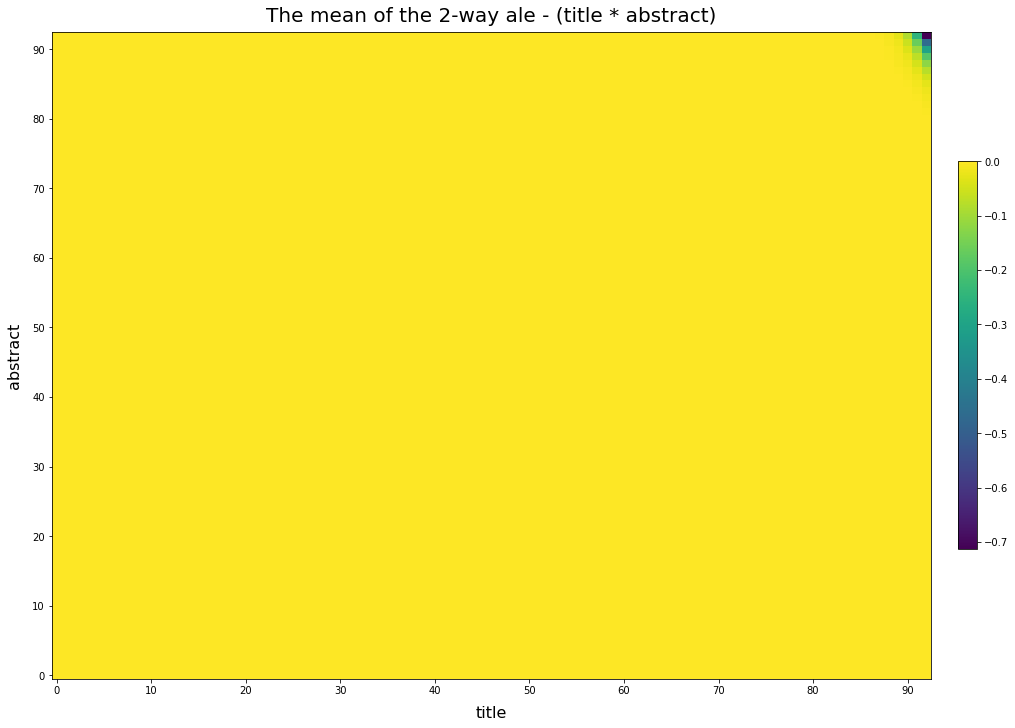

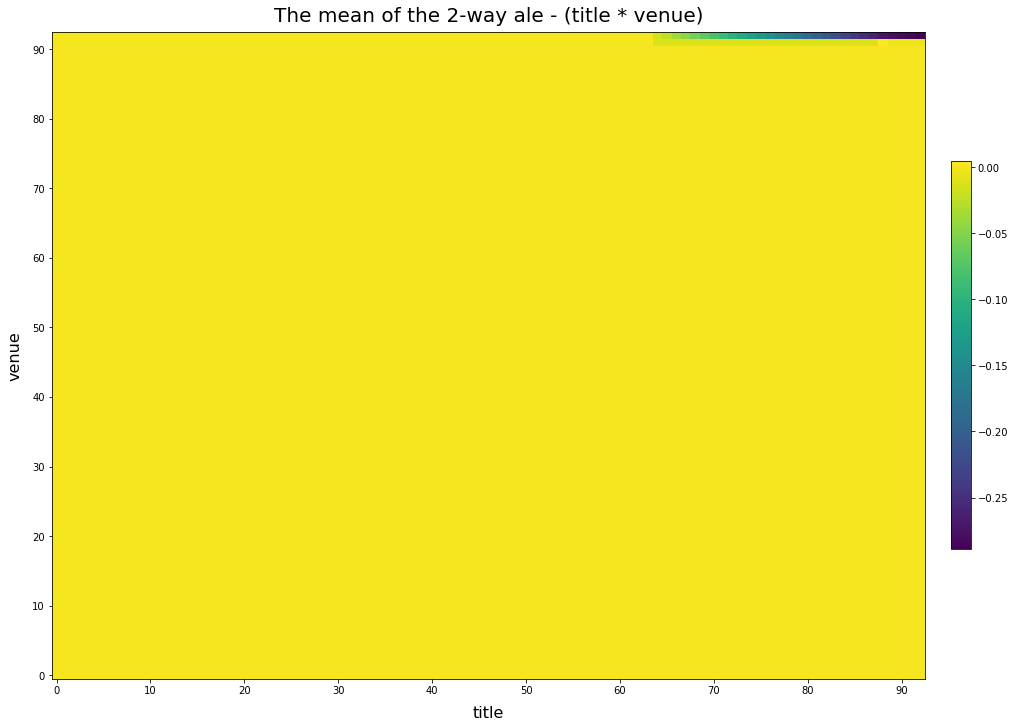

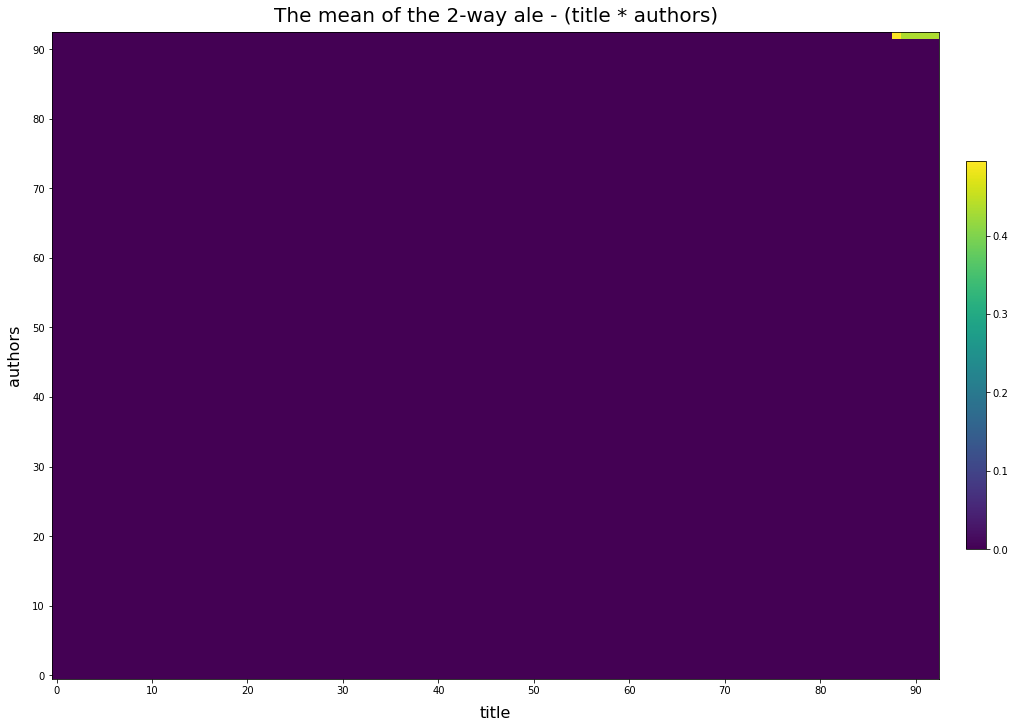

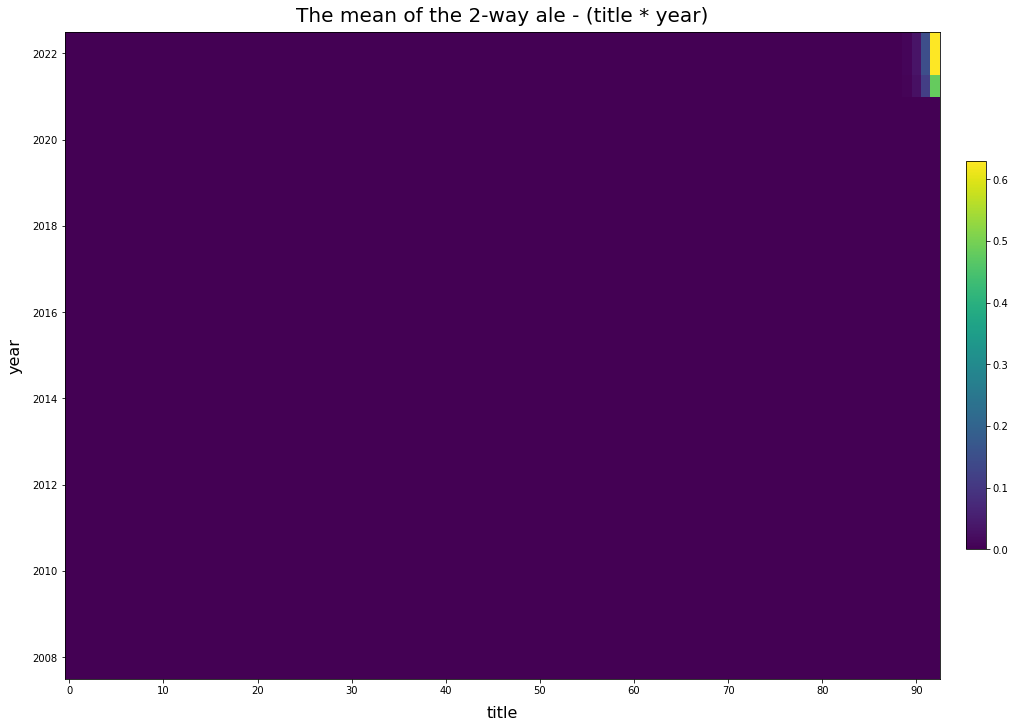

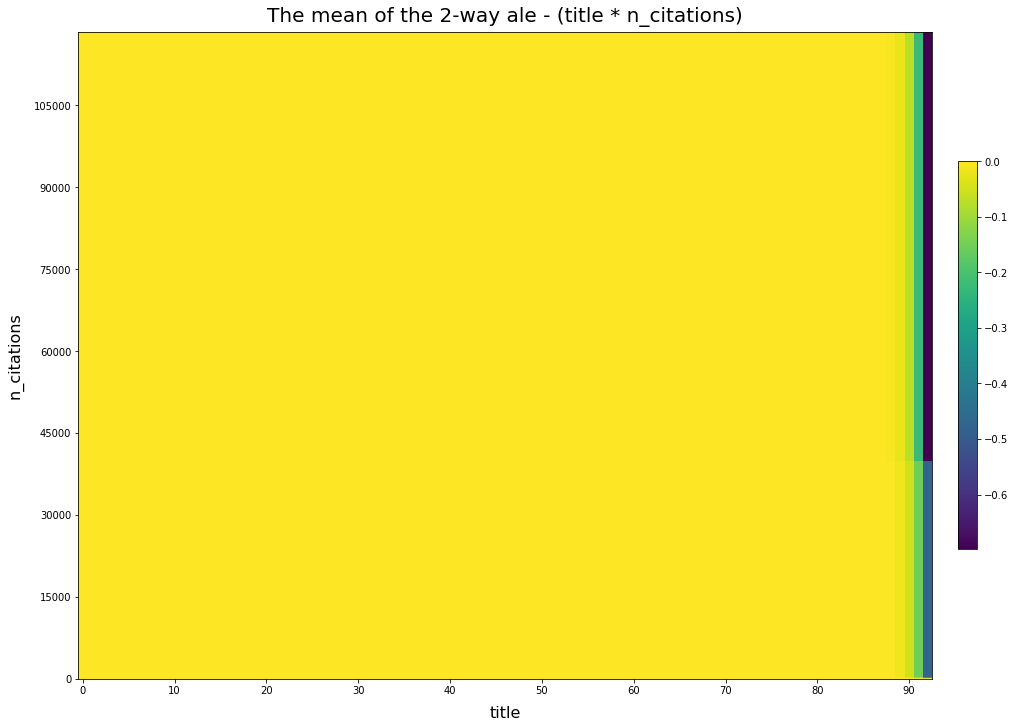

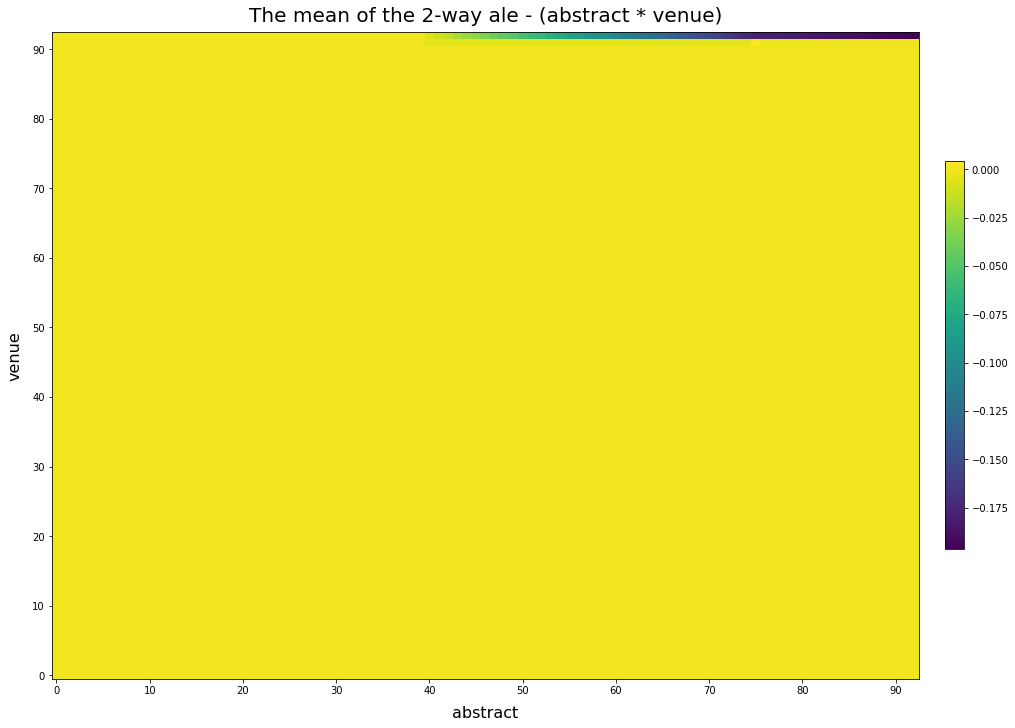

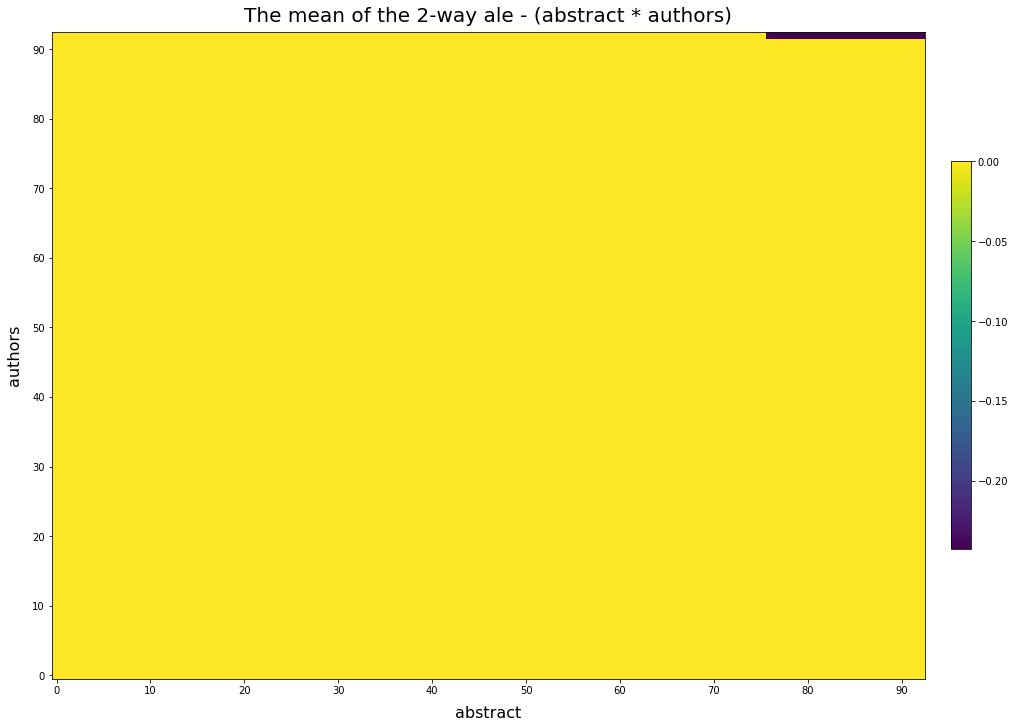

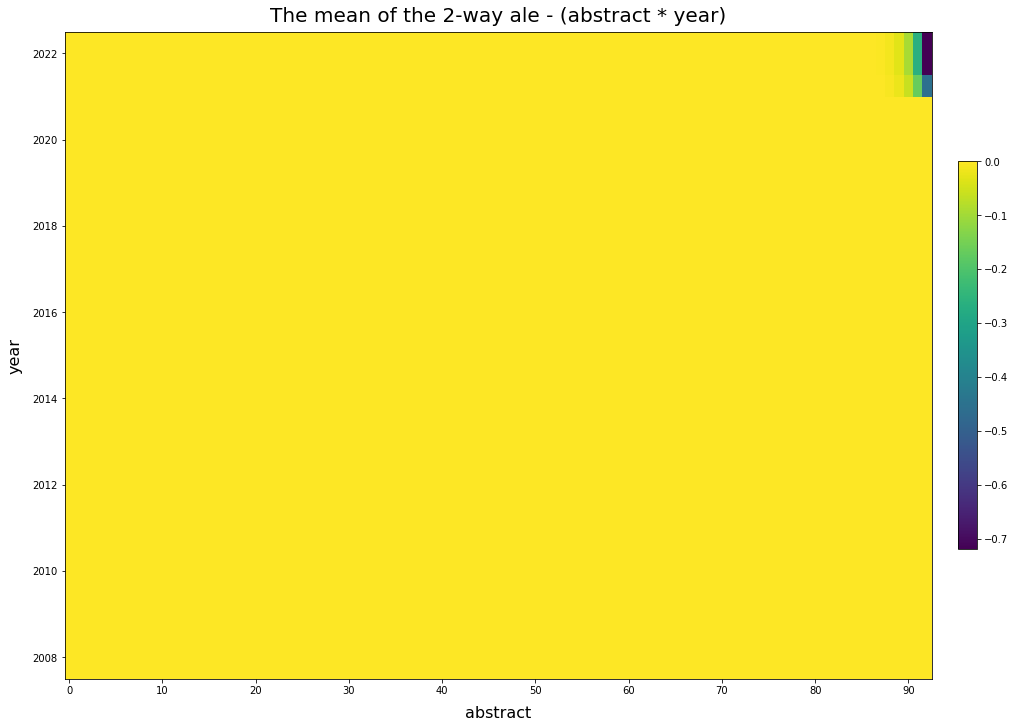

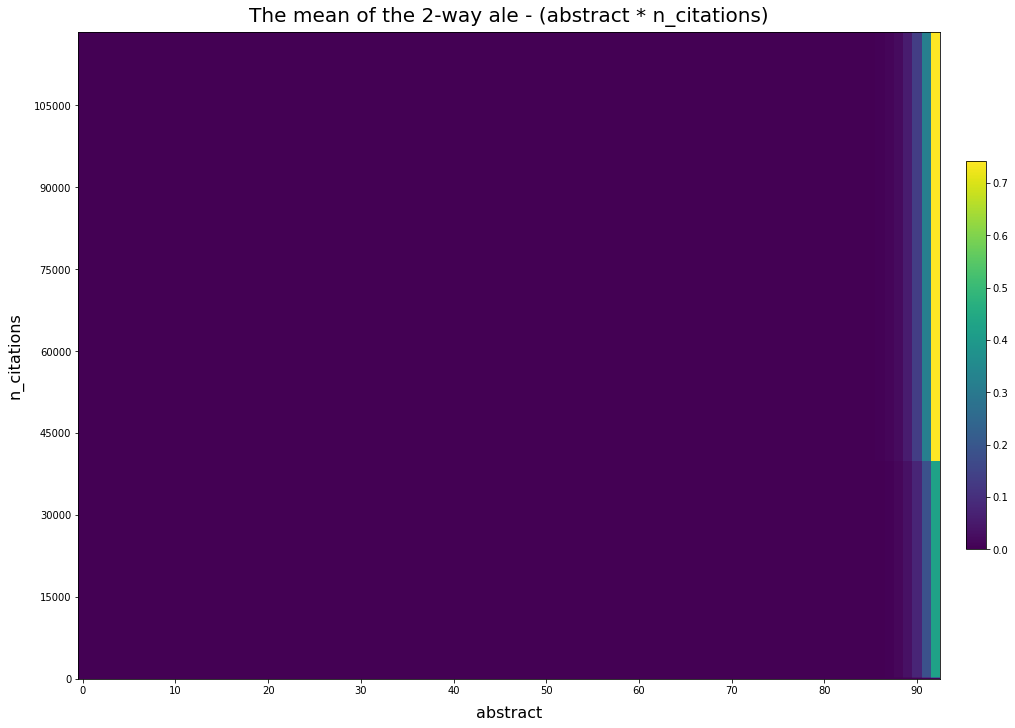

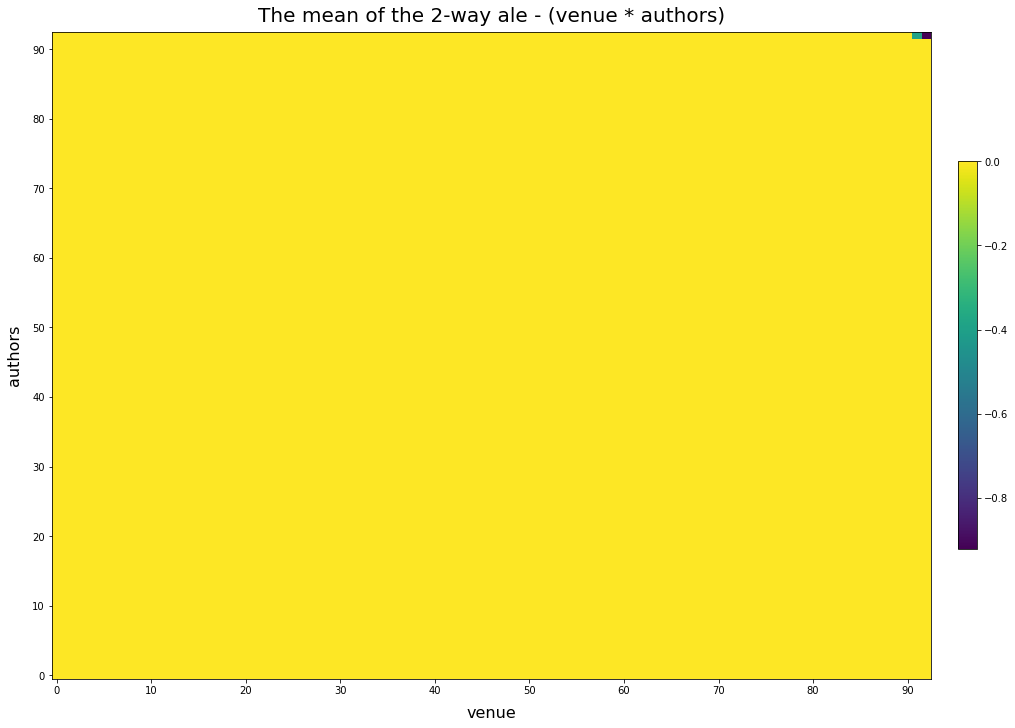

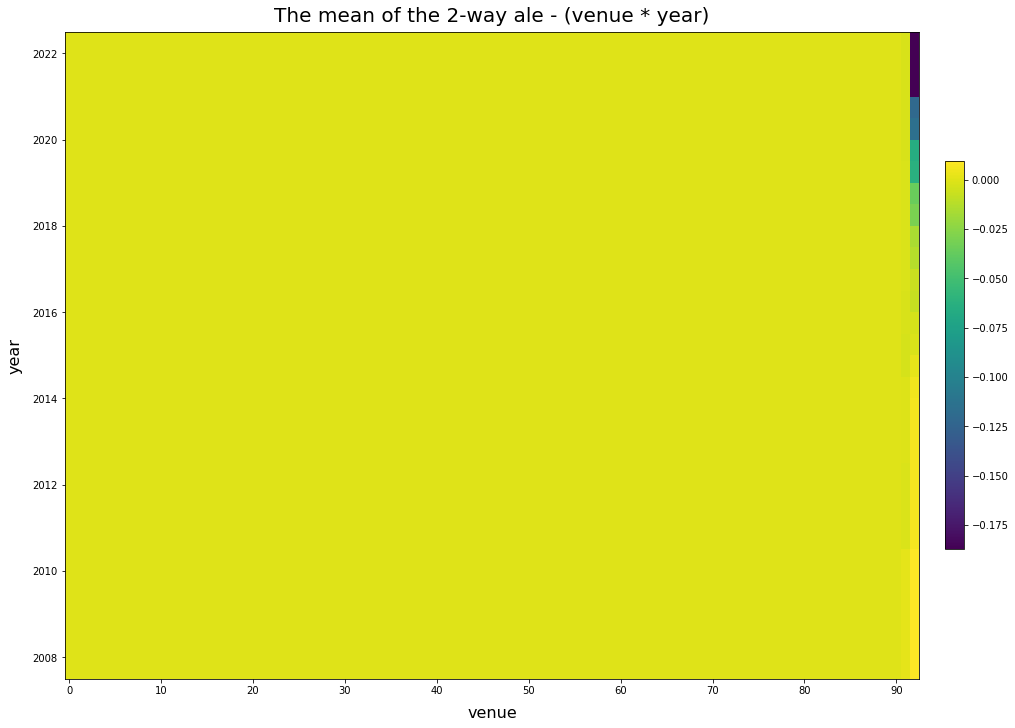

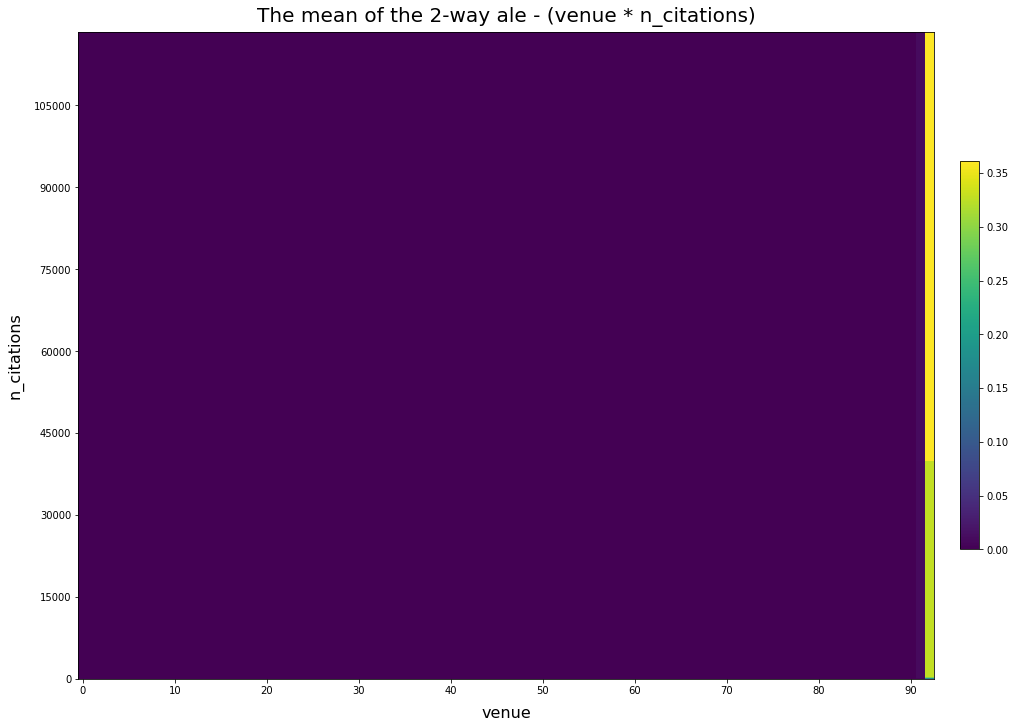

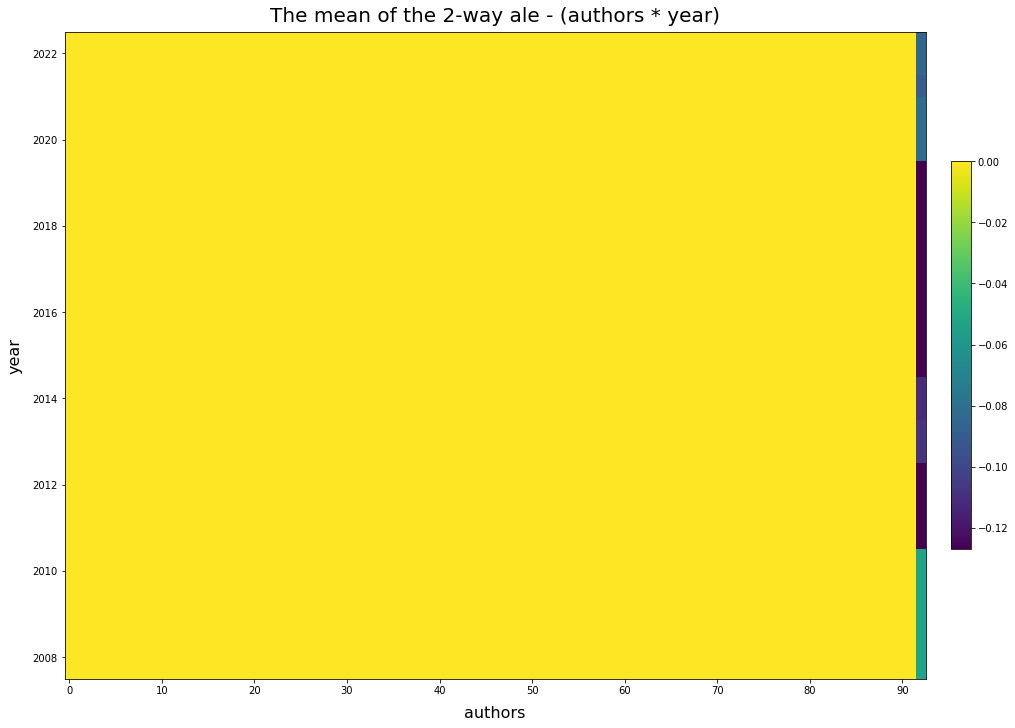

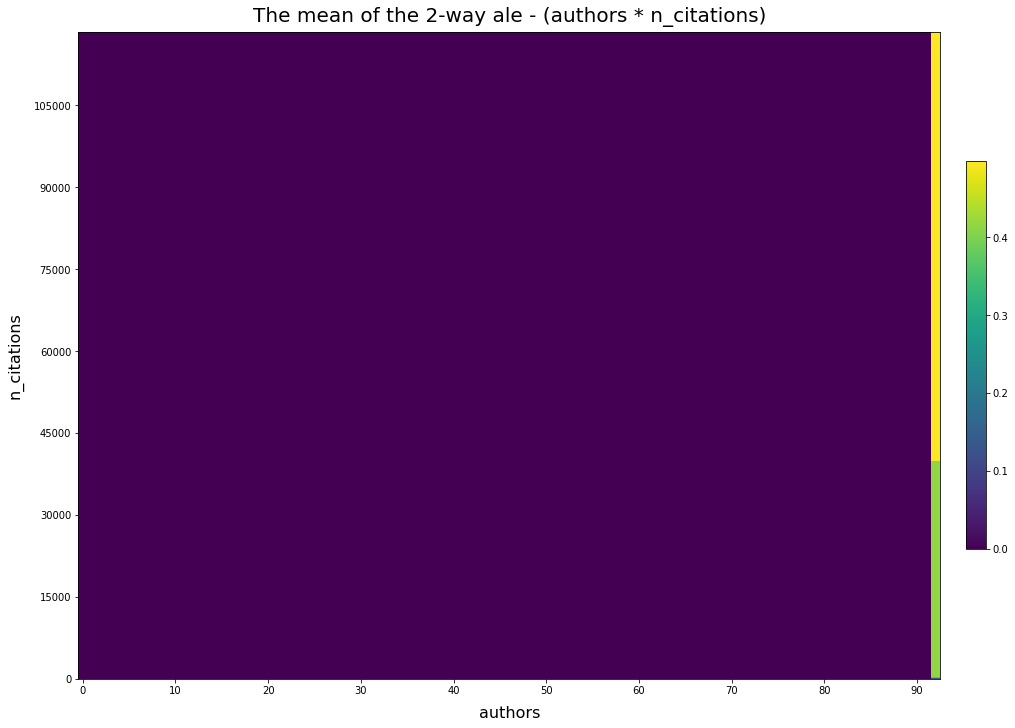

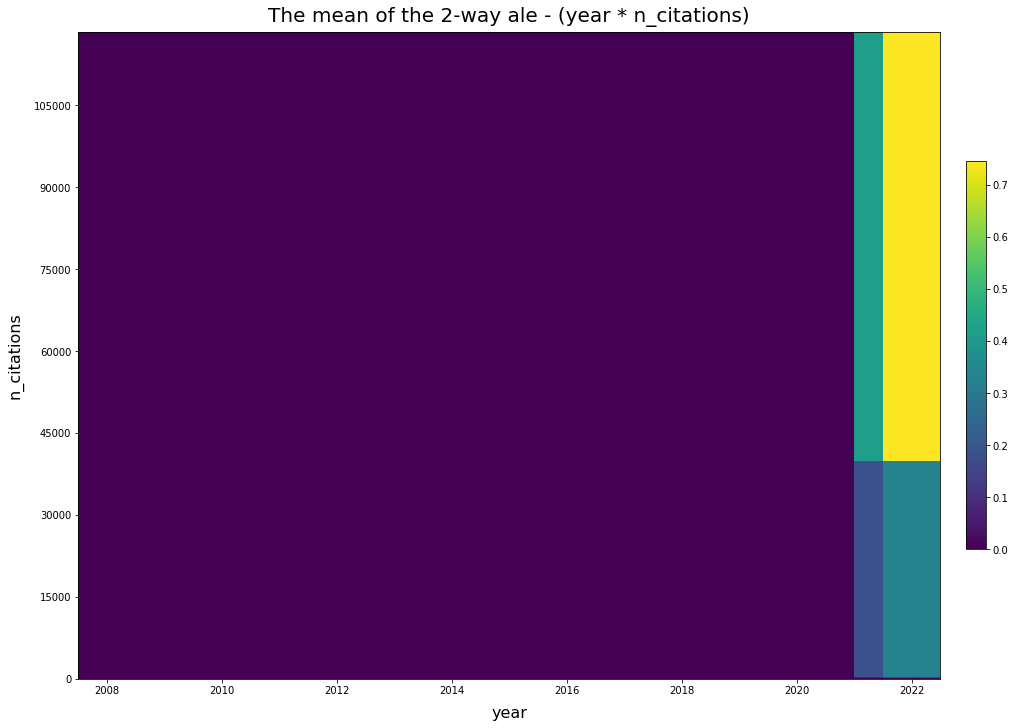

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

for ale in ale_rs:
    fig, ax = plt.subplots(figsize=(14, 10), constrained_layout=True)
    cmap = plt.colormaps['BuGn']
    
    im = ax.pcolormesh(ale['f1_quantile'], ale['f2_quantile'], ale['ale'],  cmap=None, edgecolors='k', linewidths=0)

    # cf = ax.contourf(ale['f1_quantile'], ale['f2_quantile'], ale['ale'], levels=50, alpha=0.7)
    
    ax.set_xlabel(ale['f1_name'], fontsize=16, labelpad=10)
    ax.set_ylabel(ale['f2_name'], fontsize=16, labelpad=10)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(ale['title'], fontsize=20, pad=10)
    fig.colorbar(im, ax=ax, shrink=0.6, pad=0.03)
    plt.savefig(os.path.join('.', 'plot', f"{sample_name}-2wale-{ale['f1_name']}-{ale['f2_name']}.png"), facecolor='white', transparent=False, bbox_inches='tight')
